## Basic Feature Engineering With Time Series Data in Python
### Adapted from:
- https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
- https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

In [1]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


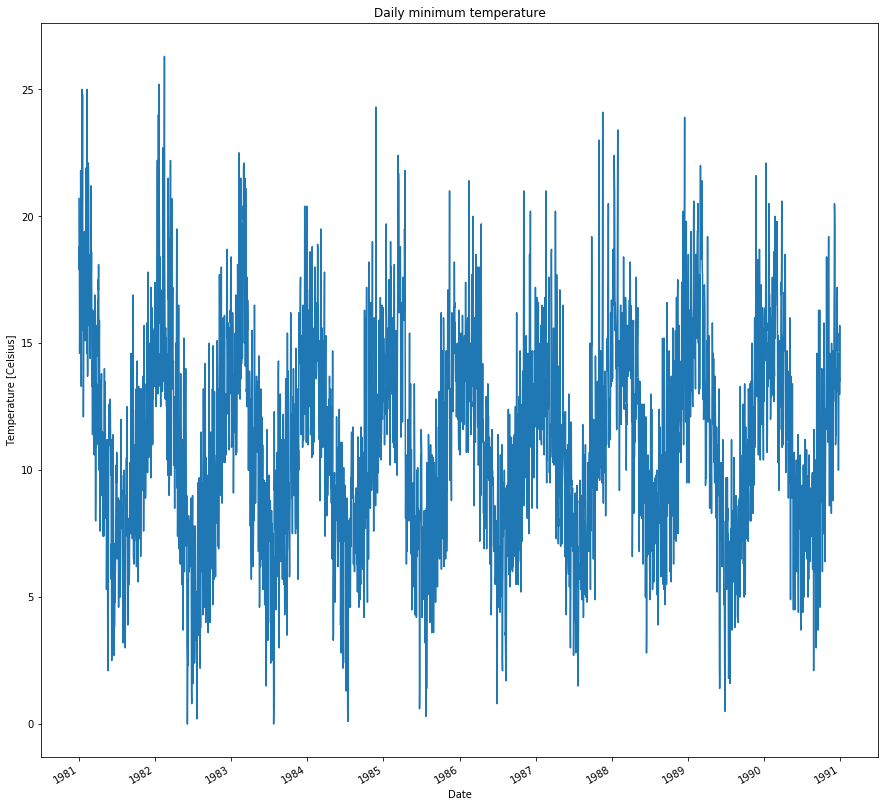

In [2]:
series = pd.Series.from_csv('DailyMinimumTemperatures.csv', header=0)

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(15)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Daily minimum temperature')
ax.set_ylabel('Temperature [Celsius]')
ax.set_xlabel('Date')

print series.head(5)

series.plot()
plt.show()

## Lag Features

In [3]:
dataframe = pd.DataFrame()

dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['temperature'] = [series[i] for i in range(len(series))]

print(dataframe.head(5))

   month  day  temperature
0      1    1         20.7
1      1    2         17.9
2      1    3         18.8
3      1    4         14.6
4      1    5         15.8


- The addition of lag features is called the sliding window method
- It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width
- A difficulty with the sliding window approach is how large to make the window for your problem
- **Perhaps a good starting point is to perform a sensitivity analysis and try a suite of different window widths to in turn create a suite of different “views” of your dataset and see which results in better performing models. There will be a point of diminishing returns.**
- Additionally, why stop with a linear window? Perhaps you need a lag value from last week, last month, and last year. Again, this comes down to the specific domain.
- In the case of the temperature dataset, a lag value from the same day in the previous year or previous few years may be useful.





In [4]:
temps = pd.DataFrame(series.values)

dataframe = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't+1']

print(dataframe.head(5))

    t-3   t-2   t-1   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8


## Rolling Window Statistics
- A step beyond adding raw lagged values is to add a summary of the values at previous time steps.
- We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean.
- For example, we can calculate the mean of the previous two values and use that to predict the next value.

In [7]:
temps = pd.DataFrame(series.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

dataframe = pd.concat([means, temps], axis=1)
dataframe.columns = ['mean(t-2,t-1)', 't+1']

print(dataframe.head(5))

   mean(t-2,t-1)   t+1
0            NaN  20.7
1            NaN  17.9
2          19.30  18.8
3          18.35  14.6
4          16.70  15.8


- There are more statistics we can calculate and even different mathematical ways of calculating the definition of the “window.”
- Below is another example that shows a window width of 3 and a dataset comprised of more summary statistics, specifically the minimum, mean, and maximum value in the window.
- You can see in the code that we are explicitly specifying the sliding window width as a named variable. This lets us use it both in calculating the correct shift of the series and in specifying the width of the window to the rolling() function.
- In this case, the window width of 3 means we must shift the series forward by 2 time steps. This makes the first two rows NaN. Next, we need to calculate the window statistics with 3 values per window. It takes 3 rows before we even have enough data from the series in the window to start calculating statistics.

In [10]:
temps = pd.DataFrame(series.values)
width = 3

shifted = temps.shift(width - 1)
window = shifted.rolling(window=width)

dataframe = pd.concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']

print(dataframe.head(10))

    min       mean   max   t+1
0   NaN        NaN   NaN  20.7
1   NaN        NaN   NaN  17.9
2   NaN        NaN   NaN  18.8
3   NaN        NaN   NaN  14.6
4  17.9  19.133333  20.7  15.8
5  14.6  17.100000  18.8  15.8
6  14.6  16.400000  18.8  15.8
7  14.6  15.400000  15.8  17.4
8  15.8  15.800000  15.8  21.8
9  15.8  16.333333  17.4  20.0


## Expanding Window Statistics
- Another type of window that may be useful includes all previous data in the series.
- This is called an expanding window and can help with keeping track of the bounds of observable data. Like the rolling() function on DataFrame, Pandas provides an expanding() function that collects sets of all prior values for each time step.
- These lists of prior numbers can be summarized and included as new features.
- For example, below are the lists of numbers in the expanding window for the first 5 time steps of the series

In [14]:
temps = pd.DataFrame(series.values)
window = temps.expanding()

dataframe = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']

print(dataframe.head(10))

    min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8
5  14.6  17.266667  20.7  15.8
6  14.6  17.057143  20.7  17.4
7  14.6  17.100000  20.7  21.8
8  14.6  17.622222  21.8  20.0
9  14.6  17.860000  21.8  16.2
